In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from mixed_naive_bayes import MixedNB

In [2]:
names = [
    'age',
    'class_of_worker',
    'industry_code',
    'occupation_code',
   # 'adjusted_gross_income',
    'education',
    'wage_per_hour',
    'enrolled_in_edu_inst_last_wk',
    'marital_status',
    'major_industry_code',
    'major_occupation_code',
    'race',
    'hispanic_Origin',
    'sex',
    'member_of_a_labor_union',
    'reason_for_unemployment',
    'full_or_part_time_employment_stat',
    'capital_gains',
    'capital_losses',
    'divdends_from_stocks',
    #'federal_income_tax_liability',
    'tax_filer_status',
    'region_of_previous_residence',
    'state_of_previous_residence',
    'detailed_household_and_family_stat',
    'detailed_household_summary_in_household',
    'instance_weight',
    'migration_code-change_in_msa',
    'migration_code-change_in_reg',
    'migration_code-move_within_reg',
    'live_in_this_house_1_year_ago',
    'migration_prev_res_in_sunbelt',
    'num_persons_worked_for_employer',
    'family_members_under_18',
    #'total_person_earnings',
    'country_of_birth_father',
    'country_of_birth_mother',
    'country_of_birth_self',
    'citizenship',
    #'total person income',
    'own_business_or_self_employed',
    #'taxable_income_amount',
    "fill_inc_questionnaire_for_veteran's_admin",
    'veterans_benefits',
    'weeks_worked_in_year',
    'year',
    'label'
]
train = pd.read_csv("census-income.data", names=names, header=None, na_values=' ?')
test = pd.read_csv("census-income.test", names=names, header=None, na_values=' ?')
#Basic text data is cleaned
train = train.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
test = test.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
train=train.replace(['Not in universe','?','Not in universe or children','Do not know',
                    'Not in universe under 1 year old','NA'],np.nan)
test=test.replace(['Not in universe','?','Not in universe or children','Do not know',
                    'Not in universe under 1 year old','NA'],np.nan)
train

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,label
0,73,NaN,0,0,High school graduate,0,NaN,Widowed,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,NaN,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.
2,18,NaN,0,0,10th grade,0,High school,Never married,NaN,NaN,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,NaN,2,0,95,- 50000.
3,9,NaN,0,0,Children,0,NaN,Never married,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
4,10,NaN,0,0,Children,0,NaN,Never married,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,NaN,0,0,7th and 8th grade,0,NaN,Married-civilian spouse present,NaN,NaN,...,Canada,United-States,United-States,Native- Born in the United States,0,NaN,2,0,95,- 50000.
199519,65,Self-employed-incorporated,37,2,11th grade,0,NaN,Married-civilian spouse present,Business and repair services,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.
199520,47,NaN,0,0,Some college but no degree,0,NaN,Married-civilian spouse present,NaN,NaN,...,Poland,Poland,Germany,Foreign born- U S citizen by naturalization,0,NaN,2,52,95,- 50000.
199521,16,NaN,0,0,10th grade,0,High school,Never married,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,0,95,- 50000.


In [3]:
# instance weight is ignorable for classification but needed for interpretation
# it is the number of people that each record represents due to sampling
instance_weight_train = train['instance_weight']
instance_weight_test = test['instance_weight']
train.drop(['instance_weight'], axis=1, inplace=True)
test.drop(['instance_weight'], axis=1, inplace=True)

In [4]:
# remap label to 0 and 1
train['label'] = train['label'].map({'- 50000.': 0, '50000+.': 1})
test['label'] = test['label'].map({'- 50000.': 0, '50000+.': 1})
test.label.value_counts()

0    93576
1     6186
Name: label, dtype: int64

In [5]:
# present in training but not in testing, need to drop
# {'detailed_household_and_family_stat_ Grandchild <18 ever marr not in subfamily'}
# idx = train.columns.get_loc('detailed_household_and_family_stat')
train.drop('detailed_household_and_family_stat', axis=1, inplace=True)
test.drop('detailed_household_and_family_stat', axis=1, inplace=True)

In [6]:
# see census-income.names for nominal variables
# in addition to cols with dtype object, these variables need to be converted
# ['industry_code', 'occupation_code', 'own_business_or_self_employed', 'veterans_benefits', 'year']
to_enc = train.columns[train.dtypes == 'object'].tolist() + \
    ['industry_code', 'occupation_code', 'own_business_or_self_employed', 'veterans_benefits', 'year']
train_enc = pd.get_dummies(train, columns=to_enc)
test_enc = pd.get_dummies(test, columns=to_enc)
print(train_enc.shape, test_enc.shape)  # 448

(199523, 448) (99762, 448)


In [7]:
#training dataset without any feature selection
X_train = train_enc.drop(['label'],axis=1)
X_test = test_enc.drop(['label'],axis=1)
y_train = train_enc['label']
y_test = test_enc['label']
X_train

,age,wage_per_hour,capital_gains,capital_losses,divdends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year,class_of_worker_Federal government,class_of_worker_Local government,class_of_worker_Never worked,...,occupation_code_45,occupation_code_46,own_business_or_self_employed_0,own_business_or_self_employed_1,own_business_or_self_employed_2,veterans_benefits_0,veterans_benefits_1,veterans_benefits_2,year_94,year_95
0,73,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
1,58,0,0,0,0,1,52,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2,18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
3,9,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,10,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
199519,65,0,6418,0,9,1,52,0,0,0,...,0,0,1,0,0,0,0,1,1,0
199520,47,0,0,0,157,6,52,0,0,0,...,0,0,1,0,0,0,0,1,0,1
199521,16,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1


In [8]:
# feature selection w/random forest
rf = RandomForestClassifier(n_estimators=100,
                            max_features='sqrt',
                            oob_score=True,
                            n_jobs=-1,
                            random_state=0,)
rf.fit(X_train, y_train)
# feature importances
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
# depends on the impurity threshold we set
less = importances[importances > 0.01].sort_values(ascending=False)
col_RF = list(less.index)
col_RF

['age',
 'divdends_from_stocks',
 'capital_gains',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year',
 'capital_losses',
 'major_occupation_code_Executive admin and managerial',
 'sex_Male',
 'education_Masters degree(MA MS MEng MEd MSW MBA)',
 'occupation_code_2',
 'education_Bachelors degree(BA AB BS)',
 'sex_Female',
 'major_occupation_code_Professional specialty',
 'detailed_household_summary_in_household_Householder',
 'education_High school graduate',
 'education_Prof school degree (MD DDS DVM LLB JD)',
 'tax_filer_status_Joint both under 65']

In [9]:
# reduce from 447 to 17
#create new train and test dataset with random forest pick
X_train_RF = X_train[col_RF]
X_test_RF = X_test[col_RF]
X_train_RF

,age,divdends_from_stocks,capital_gains,num_persons_worked_for_employer,weeks_worked_in_year,capital_losses,major_occupation_code_Executive admin and managerial,sex_Male,education_Masters degree(MA MS MEng MEd MSW MBA),occupation_code_2,education_Bachelors degree(BA AB BS),sex_Female,major_occupation_code_Professional specialty,detailed_household_summary_in_household_Householder,education_High school graduate,education_Prof school degree (MD DDS DVM LLB JD),tax_filer_status_Joint both under 65
0,73,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,58,0,0,1,52,0,0,1,0,0,0,0,0,1,0,0,0
2,18,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
199519,65,9,6418,1,52,0,1,1,0,1,0,0,0,1,0,0,0
199520,47,157,0,6,52,0,0,1,0,0,0,0,0,1,0,0,1
199521,16,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [10]:
# feature selection w/kBest
feature = SelectKBest(score_func=chi2, k=2)
feature.fit(X_train, y_train)
scores = []
for i in range(X_train.shape[1]):
    score = feature.scores_[i]
    scores.append((score, X_train.columns[i]))
    
top20 = sorted(scores, reverse = True)[:20]
important = [feature[1] for feature in top20]
important

['capital_gains',
 'divdends_from_stocks',
 'capital_losses',
 'weeks_worked_in_year',
 'wage_per_hour',
 'age',
 'num_persons_worked_for_employer',
 'major_occupation_code_Executive admin and managerial',
 'occupation_code_2',
 'major_occupation_code_Professional specialty',
 'education_Prof school degree (MD DDS DVM LLB JD)',
 'education_Masters degree(MA MS MEng MEd MSW MBA)',
 'education_Bachelors degree(BA AB BS)',
 'detailed_household_summary_in_household_Householder',
 'tax_filer_status_Joint both under 65',
 'tax_filer_status_Nonfiler',
 'occupation_code_0',
 'industry_code_0',
 'occupation_code_7',
 'class_of_worker_Self-employed-incorporated']

In [11]:
# reduce from 447 to 20
#create new train and test dataset with kbest pick
X_train_KB = X_train[important]
X_test_KB = X_test[important]
X_train_KB

,capital_gains,divdends_from_stocks,capital_losses,weeks_worked_in_year,wage_per_hour,age,num_persons_worked_for_employer,major_occupation_code_Executive admin and managerial,occupation_code_2,major_occupation_code_Professional specialty,education_Prof school degree (MD DDS DVM LLB JD),education_Masters degree(MA MS MEng MEd MSW MBA),education_Bachelors degree(BA AB BS),detailed_household_summary_in_household_Householder,tax_filer_status_Joint both under 65,tax_filer_status_Nonfiler,occupation_code_0,industry_code_0,occupation_code_7,class_of_worker_Self-employed-incorporated
0,0,0,0,0,0,73,0,0,0,0,0,0,0,0,0,1,1,1,0,0
1,0,0,0,52,0,58,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,1,1,1,0,0
3,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,1,1,1,0,0
4,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,0,0,0,0,0,87,0,0,0,0,0,0,0,1,0,0,1,1,0,0
199519,6418,9,0,52,0,65,1,1,1,0,0,0,0,1,0,0,0,0,0,1
199520,0,157,0,52,0,47,6,0,0,0,0,0,0,1,1,0,1,1,0,0
199521,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,1,1,1,0,0


In [8]:
#Then feature selection with lasso regression
lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score)
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)
print("\n")
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("training score for alpha= 0.01:", train_score001) 
print ("test score for alpha = 0.01: ", test_score001)
print ("number of features used: for alpha = 0.01:", coeff_used001)
print("\n")
lasso005 = Lasso(alpha=0.005, max_iter=10e5)
lasso005.fit(X_train,y_train)
train_score005=lasso005.score(X_train,y_train)
test_score005=lasso005.score(X_test,y_test)
coeff_used005 = np.sum(lasso005.coef_!=0)
print ("training score for alpha= 0.005:", train_score005 )
print ("test score for alpha = 0.005: ", test_score005)
print ("number of features used: for alpha = 0.005:", coeff_used005)
print("\n")
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)
print ("LR training score:", lr_train_score )
print ("LR test score: ", lr_test_score)

training score: 0.12334496018090002
test score:  0.12600392716094067
number of features used:  4


training score for alpha= 0.01: 0.16625136676913244
test score for alpha = 0.01:  0.16979236491295147
number of features used: for alpha = 0.01: 10


training score for alpha= 0.005: 0.20892302466190094
test score for alpha = 0.005:  0.21280455668435838
number of features used: for alpha = 0.005: 16


LR training score: 0.3137517950795635
LR test score:  0.31554891958561826


In [9]:
#In alpha = 0.005, reduce from 447 to 16 but in the big cost of accuracy in at  least linear regression. 
#We will try those features in our plan models to see how these perform as well
features = []
for i in range(X_train.shape[1]):
    feature = lasso005.coef_[i]
    features.append((feature, X_train.columns[i]))
    
features_lasso = sorted(features, reverse = True)
lasso_features = [feature for feature in features_lasso if feature[0] != 0]
final_lasso = [feature[1] for feature in lasso_features]
lasso_features

[(0.06966793889950086, 'major_occupation_code_Executive admin and managerial'),
 (0.04555635443397677, 'major_occupation_code_Professional specialty'),
 (0.005088009528619055, 'num_persons_worked_for_employer'),
 (0.004755082330769386, 'detailed_household_summary_in_household_Householder'),
 (0.0035502481794541948, 'tax_filer_status_Joint both under 65'),
 (0.003281872552894073, 'education_Bachelors degree(BA AB BS)'),
 (0.0015108166263765495, 'weeks_worked_in_year'),
 (0.0007401410445909137, 'age'),
 (9.691033351989998e-05, 'capital_losses'),
 (1.5859210647824184e-05, 'divdends_from_stocks'),
 (9.769573895177861e-06, 'capital_gains'),
 (2.968241918663065e-17, 'sex_Male'),
 (-1.6196313980702442e-05, 'wage_per_hour'),
 (-0.015202162430726668, 'tax_filer_status_Single'),
 (-0.025885379794678937, 'education_High school graduate'),
 (-0.03661256139220707, 'sex_Female')]

In [14]:
#create new train and test dataset with lasso pick
X_train_lasso = X_train[final_lasso]
X_test_lasso = X_test[final_lasso]
X_train_lasso

,major_occupation_code_Executive admin and managerial,major_occupation_code_Professional specialty,num_persons_worked_for_employer,detailed_household_summary_in_household_Householder,tax_filer_status_Joint both under 65,education_Bachelors degree(BA AB BS),weeks_worked_in_year,age,capital_losses,divdends_from_stocks,capital_gains,sex_Male,wage_per_hour,tax_filer_status_Single,education_High school graduate,sex_Female
0,0,0,0,0,0,0,0,73,0,0,0,0,0,0,1,1
1,0,0,1,1,0,0,52,58,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,0,0,0,1,0,0,0,87,0,0,0,1,0,0,0,0
199519,1,0,1,1,0,0,52,65,0,9,6418,1,0,0,0,0
199520,0,0,6,1,1,0,52,47,0,157,0,1,0,0,0,0
199521,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,1


In [15]:
#Normalize all train  data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train_RF = pd.get_dummies(X_train_RF)
X_test_RF = pd.get_dummies(X_test_RF)
X_train_RF = scaler.fit_transform(X_train_RF)
X_test_RF = scaler.fit_transform(X_test_RF)

X_train_KB = pd.get_dummies(X_train_KB)
X_test_KB = pd.get_dummies(X_test_KB)
X_train_KB = scaler.fit_transform(X_train_KB)
X_test_KB = scaler.fit_transform(X_test_KB)

X_train_lasso = pd.get_dummies(X_train_lasso)
X_test_lasso = pd.get_dummies(X_test_lasso)
X_train_lasso = scaler.fit_transform(X_train_lasso)
X_test_lasso = scaler.fit_transform(X_test_lasso)

In [16]:
# Since our data has continous and categorical variables, it's better use mixed type naive bayesian
# so we don't assume all data follow gaussian distribution or bernoulli distribution. 
# since the categorical data be label-encoded accordingly, we need a new cleansed data without dummy variable
# by reading name file, we can find all nominal value excluding instance weight

categorical_features = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,39]
train_MT = pd.read_csv("census-income.data", names=names, header=None, na_values=' ?')
test_MT = pd.read_csv("census-income.test", names=names, header=None, na_values=' ?')
train_MT = train_MT.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
test_MT = test_MT.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
train_MT =train_MT.replace(['Not in universe','?','Not in universe or children','Do not know',
                    'Not in universe under 1 year old','NA'],np.nan)
test_MT=test_MT.replace(['Not in universe','?','Not in universe or children','Do not know',
                    'Not in universe under 1 year old','NA'],np.nan)
train_MT['label'] = train_MT['label'].map({'- 50000.': 0, '50000+.': 1})
test_MT['label'] = test_MT['label'].map({'- 50000.': 0, '50000+.': 1})
train_MT.drop(['instance_weight'], axis=1, inplace=True)
test_MT.drop(['instance_weight'], axis=1, inplace=True)

le = LabelEncoder()
for i in categorical_features:
    train_MT.iloc[:,i] = le.fit_transform(train_MT.iloc[:,i])
    test_MT.iloc[:,i] = le.fit_transform(test_MT.iloc[:,i])

X_train_MT = train_MT.drop(['label'],axis=1)
X_test_MT = test_MT.drop(['label'],axis=1)
y_train_MT = train_MT['label']
y_test_MT = test_MT['label']

X_train_MT

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year
0,73,8,0,0,12,0,2,6,23,14,...,4,39,39,39,4,0,2,2,0,1
1,58,5,4,34,16,0,2,0,4,7,...,4,39,39,39,4,0,2,2,52,0
2,18,8,0,0,0,0,1,4,23,14,...,4,40,40,40,0,0,2,2,0,1
3,9,8,0,0,10,0,2,4,23,14,...,0,39,39,39,4,0,2,0,0,0
4,10,8,0,0,10,0,2,4,23,14,...,0,39,39,39,4,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,8,0,0,5,0,2,2,23,14,...,4,1,39,39,4,0,2,2,0,1
199519,65,4,37,2,1,0,2,2,2,2,...,4,39,39,39,4,0,2,2,52,0
199520,47,8,0,0,16,0,2,2,23,14,...,4,31,31,10,1,0,2,2,52,1
199521,16,8,0,0,0,0,1,4,23,14,...,0,39,39,39,4,0,2,2,0,1


In [17]:
# now since MTNB require different form of data then need to do features select special for it
# feature selection w/random forest
rf = RandomForestClassifier(n_estimators=100,
                            max_features='sqrt',
                            oob_score=True,
                            n_jobs=-1,
                            random_state=0,)
rf.fit(X_train_MT, y_train)
# feature importances
importances = pd.Series(rf.feature_importances_, index=X_train_MT.columns)
# depends on the impurity threshold we set
less = importances[importances > 0.01].sort_values(ascending=False)
col_RF = list(less.index)
X_train_MT_RF = X_train_MT[col_RF]
X_test_MT_RF = X_test_MT[col_RF]
X_train_MT_RF

,age,occupation_code,divdends_from_stocks,capital_gains,education,industry_code,major_industry_code,num_persons_worked_for_employer,weeks_worked_in_year,sex,...,marital_status,detailed_household_and_family_stat,country_of_birth_father,own_business_or_self_employed,country_of_birth_mother,member_of_a_labor_union,wage_per_hour,full_or_part_time_employment_stat,detailed_household_summary_in_household,race
0,73,0,0,0,12,0,23,0,0,0,...,6,24,39,0,39,2,0,2,6,4
1,58,34,0,0,16,4,4,1,52,1,...,0,20,39,0,39,2,0,0,4,4
2,18,0,0,0,0,0,23,0,0,0,...,4,2,40,0,40,2,0,2,0,1
3,9,0,0,0,10,0,23,0,0,0,...,4,8,39,0,39,2,0,0,2,4
4,10,0,0,0,10,0,23,0,0,0,...,4,8,39,0,39,2,0,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,0,0,0,5,0,23,0,0,1,...,2,20,1,0,39,2,0,2,4,4
199519,65,2,9,6418,1,37,2,1,52,1,...,2,20,39,0,39,2,0,0,4,4
199520,47,0,157,0,16,0,23,6,52,1,...,2,20,31,0,31,2,0,0,4,4
199521,16,0,0,0,0,0,23,0,0,0,...,4,8,39,0,39,2,0,2,2,4


In [18]:
#now since MTNB require different form of data then need to do features select special for it
# feature selection w/kBest
feature = SelectKBest(score_func=chi2, k=2)
feature.fit(X_train_MT, y_train)
scores = []
for i in range(X_train_MT.shape[1]):
    score = feature.scores_[i]
    scores.append((score, X_train_MT.columns[i]))
    
top20 = sorted(scores, reverse = True)[:20]
important = [feature[1] for feature in top20]
X_train_MT_KB = X_train_MT[important]
X_test_MT_KB = X_test_MT[important]
X_train_MT_KB

,capital_gains,divdends_from_stocks,capital_losses,weeks_worked_in_year,wage_per_hour,industry_code,age,num_persons_worked_for_employer,major_industry_code,major_occupation_code,class_of_worker,detailed_household_and_family_stat,family_members_under_18,education,hispanic_Origin,marital_status,sex,tax_filer_status,veterans_benefits,detailed_household_summary_in_household
0,0,0,0,0,0,0,73,0,23,14,8,24,4,12,0,6,0,4,2,6
1,0,0,0,52,0,4,58,1,4,7,5,20,4,16,0,0,1,0,2,4
2,0,0,0,0,0,0,18,0,23,14,8,2,4,0,0,4,0,4,2,0
3,0,0,0,0,0,0,9,0,23,14,8,8,0,10,0,4,0,4,0,2
4,0,0,0,0,0,0,10,0,23,14,8,8,0,10,0,4,0,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,0,0,0,0,0,0,87,0,23,14,8,20,4,5,0,2,1,1,2,4
199519,6418,9,0,52,0,37,65,1,2,2,4,20,4,1,0,2,1,3,2,4
199520,0,157,0,52,0,0,47,6,23,14,8,20,4,16,0,2,1,2,2,4
199521,0,0,0,0,0,0,16,0,23,14,8,8,0,0,0,4,0,4,2,2


In [19]:
#now since MTNB require different form of data then need to do features select special for it
#Then feature selection with lasso regression
lasso = Lasso()
lasso.fit(X_train_MT,y_train)
train_score=lasso.score(X_train_MT,y_train)
test_score=lasso.score(X_test_MT,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score)
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)
print("\n")
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train_MT,y_train)
train_score001=lasso001.score(X_train_MT,y_train)
test_score001=lasso001.score(X_test_MT,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("training score for alpha= 0.01:", train_score001) 
print ("test score for alpha = 0.01: ", test_score001)
print ("number of features used: for alpha = 0.01:", coeff_used001)
print("\n")
lasso005 = Lasso(alpha=0.005, max_iter=10e5)
lasso005.fit(X_train_MT,y_train)
train_score005=lasso005.score(X_train_MT,y_train)
test_score005=lasso005.score(X_test_MT,y_test)
coeff_used005 = np.sum(lasso005.coef_!=0)
print ("training score for alpha= 0.005:", train_score005 )
print ("test score for alpha = 0.005: ", test_score005)
print ("number of features used: for alpha = 0.005:", coeff_used005)
print("\n")
lr = LinearRegression()
lr.fit(X_train_MT,y_train)
lr_train_score=lr.score(X_train_MT,y_train)
lr_test_score=lr.score(X_test_MT,y_test)
print ("LR training score:", lr_train_score )
print ("LR test score: ", lr_test_score)

training score: 0.12334496018090002
test score:  0.12600392716094067
number of features used:  4


training score for alpha= 0.01: 0.21354198646992717
test score for alpha = 0.01:  0.2162107787479861
number of features used: for alpha = 0.01: 17


training score for alpha= 0.005: 0.22194467679609575
test score for alpha = 0.005:  0.22471918168898886
number of features used: for alpha = 0.005: 19


LR training score: 0.22688158185009522
LR test score:  0.2302514297065138


In [20]:
features = []
for i in range(X_train_MT.shape[1]):
    feature = lasso005.coef_[i]
    features.append((feature, X_train_MT.columns[i]))
    
features_lasso = sorted(features, reverse = True)
lasso_features = [feature for feature in features_lasso if feature[0] != 0]
final_lasso = [feature[1] for feature in lasso_features]
X_train_MT_lasso = X_train_MT[final_lasso]
X_test_MT_lasso = X_test_MT[final_lasso]
X_train_MT_lasso

,sex,num_persons_worked_for_employer,weeks_worked_in_year,education,age,state_of_previous_residence,capital_losses,divdends_from_stocks,industry_code,capital_gains,wage_per_hour,hispanic_Origin,detailed_household_and_family_stat,family_members_under_18,marital_status,major_industry_code,occupation_code,tax_filer_status,class_of_worker
0,0,0,0,12,73,49,0,0,0,0,0,0,24,4,6,23,0,4,8
1,1,1,52,16,58,4,0,0,4,0,0,0,20,4,0,4,34,0,5
2,0,0,0,0,18,49,0,0,0,0,0,0,2,4,4,23,0,4,8
3,0,0,0,10,9,49,0,0,0,0,0,0,8,0,4,23,0,4,8
4,0,0,0,10,10,49,0,0,0,0,0,0,8,0,4,23,0,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,1,0,0,5,87,49,0,0,0,0,0,0,20,4,2,23,0,1,8
199519,1,1,52,1,65,49,0,9,37,6418,0,0,20,4,2,2,2,3,4
199520,1,6,52,16,47,49,0,157,0,0,0,0,20,4,2,23,0,2,8
199521,0,0,0,0,16,49,0,0,0,0,0,0,8,0,4,23,0,4,8


In [21]:
#find categorical variable position for three feature selections
columns = list(X_train_MT.iloc[:,categorical_features].columns)
#get RF categorical variavbles location
position = []
for i in list(X_train_MT_RF.columns):
    position.append(i in columns)
categorical_features_RF = []
for m,n in zip(position, list(X_train_MT_RF.columns)):
    if m:
        categorical_features_RF.append(X_train_MT_RF.columns.get_loc(n))
        
#get KB categorical variavbles location
position = []
for i in list(X_train_MT_KB.columns):
    position.append(i in columns)
categorical_features_KB = []
for m,n in zip(position, list(X_train_MT_KB.columns)):
    if m:
        categorical_features_KB.append(X_train_MT_KB.columns.get_loc(n))

#get lasso categorical variavbles location
position = []
for i in list(X_train_MT_lasso.columns):
    position.append(i in columns)
categorical_features_lasso = []
for m,n in zip(position, list(X_train_MT_lasso.columns)):
    if m:
        categorical_features_lasso.append(X_train_MT_lasso.columns.get_loc(n))

In [23]:
# train model with all features
rf_red = RandomForestClassifier(n_estimators=100,
                                max_features=None,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=0)

# logistic regression
lr = LogisticRegression()

#Naive Bayes
gnb = GaussianNB()
bnb = BernoulliNB()
Mnb = MixedNB(categorical_features)



#fit model with orginal training/testing data
rf_red.fit(X_train, y_train)
lr.fit(X_train, y_train)
gnb.fit(X_train, y_train)
bnb.fit(X_train, y_train)
Mnb.fit(X_train_MT,y_train_MT)

C:\Users\sophi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ 9 52 47 17  3  7 24 15  5  9  2  3  6  8  6  6 50 38  8  9  8  9  3  3
  5 43 43 43  5  3  3  3  2]


MixedNB(alpha=0.5, var_smoothing=1e-09)

In [24]:
#train model with RF selected features
rf_red_1 = RandomForestClassifier(n_estimators=100,
                                max_features=None,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=0)

# logistic regression
lr_1 = LogisticRegression()

#Naive Bayes
gnb_1 = GaussianNB()
bnb_1 = BernoulliNB()
Mnb_1 = MixedNB(categorical_features_RF)



#fit model with orginal training/testing data
rf_red_1.fit(X_train_RF, y_train)
lr_1.fit(X_train_RF, y_train)
gnb_1.fit(X_train_RF, y_train)
bnb_1.fit(X_train_RF, y_train)
Mnb_1.fit(X_train_MT_RF,y_train_MT)

[47 17 52 24  2 15  9  6  7 38 43  3 43  3  8  8  5]


MixedNB(alpha=0.5, var_smoothing=1e-09)

In [25]:
#train model with KB selected features
rf_red_2 = RandomForestClassifier(n_estimators=100,
                                max_features=None,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=0)

# logistic regression
lr_2 = LogisticRegression()

#Naive Bayes
gnb_2 = GaussianNB()
bnb_2 = BernoulliNB()
Mnb_2 = MixedNB(categorical_features_KB)



#fit model with orginal training/testing data
rf_red_2.fit(X_train_KB, y_train)
lr_2.fit(X_train_KB, y_train)
gnb_2.fit(X_train_KB, y_train)
bnb_2.fit(X_train_KB, y_train)
Mnb_2.fit(X_train_MT_KB,y_train_MT)

[52 24 15  9 38  5 17  9  7  2  6  3  8]


MixedNB(alpha=0.5, var_smoothing=1e-09)

In [26]:
#train model with lasso selected features
rf_red_3 = RandomForestClassifier(n_estimators=100,
                                max_features=None,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=0)

# logistic regression
lr_3 = LogisticRegression()

#Naive Bayes
gnb_3 = GaussianNB()
bnb_3 = BernoulliNB()
Mnb_3 = MixedNB(categorical_features_lasso)



#fit model with orginal training/testing data
rf_red_3.fit(X_train_lasso, y_train)
lr_3.fit(X_train_lasso, y_train)
gnb_3.fit(X_train_lasso, y_train)
bnb_3.fit(X_train_lasso, y_train)
Mnb_3.fit(X_train_MT_lasso,y_train_MT)

[ 2 17 50 52  9 38  5  7 24 47  6  9]


MixedNB(alpha=0.5, var_smoothing=1e-09)

In [27]:
#show results for model with all features:
results = pd.DataFrame(data=[["Random Forest", accuracy_score(y_train, rf_red.predict(X_train)) * 100, 
                              accuracy_score(y_test, rf_red.predict(X_test)) * 100,
                              recall_score(y_test, rf_red.predict(X_test)) * 100,
                              precision_score(y_test, rf_red.predict(X_test)) * 100,
                              f1_score(y_test, rf_red.predict(X_test)) * 100],
                             ["Logistic Regression", accuracy_score(y_train, lr.predict(X_train)) * 100,
                              accuracy_score(y_test, lr.predict(X_test)) * 100,
                              recall_score(y_test, lr.predict(X_test)) * 100,
                              precision_score(y_test, lr.predict(X_test)) * 100,
                              f1_score(y_test, lr.predict(X_test)) * 100],
                             ["GaussianNB", accuracy_score(y_train, gnb.predict(X_train)) * 100, 
                              accuracy_score(y_test, gnb.predict(X_test)) * 100,
                              recall_score(y_test, gnb.predict(X_test)) * 100,
                              precision_score(y_test, gnb.predict(X_test)) * 100,
                              f1_score(y_test, gnb.predict(X_test)) * 100],
                             ["BernoulliNB", accuracy_score(y_train, bnb.predict(X_train)) * 100, 
                              accuracy_score(y_test, bnb.predict(X_test)) * 100,
                              recall_score(y_test, bnb.predict(X_test)) * 100,
                              precision_score(y_test, bnb.predict(X_test)) * 100,
                              f1_score(y_test, bnb.predict(X_test)) * 100],
                             ["MixedNB", accuracy_score(y_train_MT, Mnb.predict(X_train_MT)) * 100, 
                              accuracy_score(y_test_MT, Mnb.predict(X_test_MT)) * 100,
                              recall_score(y_test_MT, Mnb.predict(X_test_MT)) * 100,
                              precision_score(y_test_MT, Mnb.predict(X_test_MT)) * 100,
                              f1_score(y_test_MT, Mnb.predict(X_test_MT)) * 100]], 
                       columns=['Model', 'Training Accuracy %', 'Testing Accuracy %','Testing precision %', 'Testing recall %', 'Testing f1_score %'])
results

C:\Users\sophi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Training Accuracy %,Testing Accuracy %,Testing precision %,Testing recall %,Testing f1_score %
0,Random Forest,99.952888,95.239670,46.233430,66.775625,54.637501
1,Logistic Regression,95.336878,95.333895,39.654058,72.681481,51.312624
2,GaussianNB,60.434637,93.799242,0.000000,0.000000,0.000000
3,BernoulliNB,79.019963,79.118302,88.748788,21.423554,34.515277
4,MixedNB,85.651779,89.819771,67.652764,33.914100,45.179747


In [34]:
#show results for model with RF feaures:
results_RF = pd.DataFrame(data=[["Random Forest with RF feaures", accuracy_score(y_train, rf_red_1.predict(X_train_RF)) * 100, 
                              accuracy_score(y_test, rf_red_1.predict(X_test_RF)) * 100,
                              recall_score(y_test, rf_red_1.predict(X_test_RF)) * 100,
                              precision_score(y_test, rf_red_1.predict(X_test_RF)) * 100,
                              f1_score(y_test, rf_red_1.predict(X_test_RF)) * 100],
                             ["Logistic Regression with RF feaures", accuracy_score(y_train, lr_1.predict(X_train_RF)) * 100,
                              accuracy_score(y_test, lr_1.predict(X_test_RF)) * 100,
                              recall_score(y_test, lr_1.predict(X_test_RF)) * 100,
                              precision_score(y_test, lr_1.predict(X_test_RF)) * 100,
                              f1_score(y_test, lr_1.predict(X_test_RF)) * 100],
                             ["GaussianNB with RF feaures", accuracy_score(y_train, gnb_1.predict(X_train_RF)) * 100, 
                              accuracy_score(y_test, gnb_1.predict(X_test_RF)) * 100,
                              recall_score(y_test, gnb_1.predict(X_test_RF)) * 100,
                              precision_score(y_test, gnb_1.predict(X_test_RF)) * 100,
                              f1_score(y_test, gnb_1.predict(X_test_RF)) * 100],
                             ["BernoulliNB with RF feaures", accuracy_score(y_train, bnb_1.predict(X_train_RF)) * 100, 
                              accuracy_score(y_test, bnb_1.predict(X_test_RF)) * 100,
                              recall_score(y_test, bnb_1.predict(X_test_RF)) * 100,
                              precision_score(y_test, bnb_1.predict(X_test_RF)) * 100,
                              f1_score(y_test, bnb_1.predict(X_test_RF)) * 100],
                             ["MixedNB with RF feaures", accuracy_score(y_train_MT, Mnb_1.predict(X_train_MT_RF)) * 100, 
                              accuracy_score(y_test_MT, Mnb_1.predict(X_test_MT_RF)) * 100,
                              recall_score(y_test_MT, Mnb_1.predict(X_test_MT_RF)) * 100,
                              precision_score(y_test_MT, Mnb_1.predict(X_test_MT_RF)) * 100,
                              f1_score(y_test_MT, Mnb_1.predict(X_test_MT_RF)) * 100]], 
                       columns=['Model', 'Training Accuracy %', 'Testing Accuracy %','Testing precision %', 'Testing recall %', 'Testing f1_score %'])
results_RF

,Model,Training Accuracy %,Testing Accuracy %,Testing precision %,Testing recall %,Testing f1_score %
0,Random Forest with RF feaures,98.350566,94.544015,40.898804,58.605513,48.176711
1,Logistic Regression with RF feaures,94.946447,94.951986,32.056256,70.419034,44.056876
2,GaussianNB with RF feaures,90.101893,90.207694,65.777562,34.715468,45.445915
3,BernoulliNB with RF feaures,90.208146,90.254806,69.123828,35.373925,46.798730
4,MixedNB with RF feaures,87.250593,90.873278,62.140317,36.240219,45.780980


In [35]:
#show results for model with KB featurs:
results_KB = pd.DataFrame(data=[["Random Forest with KB featurs", accuracy_score(y_train, rf_red_2.predict(X_train_KB)) * 100, 
                              accuracy_score(y_test, rf_red_2.predict(X_test_KB)) * 100,
                              recall_score(y_test, rf_red_2.predict(X_test_KB)) * 100,
                              precision_score(y_test, rf_red_2.predict(X_test_KB)) * 100,
                              f1_score(y_test, rf_red_2.predict(X_test_KB)) * 100],
                             ["Logistic Regression with KB featurs", accuracy_score(y_train, lr_2.predict(X_train_KB)) * 100,
                              accuracy_score(y_test, lr_2.predict(X_test_KB)) * 100,
                              recall_score(y_test, lr_2.predict(X_test_KB)) * 100,
                              precision_score(y_test, lr_2.predict(X_test_KB)) * 100,
                              f1_score(y_test, lr_2.predict(X_test_KB)) * 100],
                             ["GaussianNB with KB featurs", accuracy_score(y_train, gnb_2.predict(X_train_KB)) * 100, 
                              accuracy_score(y_test, gnb_2.predict(X_test_KB)) * 100,
                              recall_score(y_test, gnb_2.predict(X_test_KB)) * 100,
                              precision_score(y_test, gnb_2.predict(X_test_KB)) * 100,
                              f1_score(y_test, gnb_2.predict(X_test_KB)) * 100],
                             ["BernoulliNB with KB featurs", accuracy_score(y_train, bnb_2.predict(X_train_KB)) * 100, 
                              accuracy_score(y_test, bnb_2.predict(X_test_KB)) * 100,
                              recall_score(y_test, bnb_2.predict(X_test_KB)) * 100,
                              precision_score(y_test, bnb_2.predict(X_test_KB)) * 100,
                              f1_score(y_test, bnb_2.predict(X_test_KB)) * 100],
                             ["MixedNB with KB featurs", accuracy_score(y_train_MT, Mnb_2.predict(X_train_MT_KB)) * 100, 
                              accuracy_score(y_test_MT, Mnb_2.predict(X_test_MT_KB)) * 100,
                              recall_score(y_test_MT, Mnb_2.predict(X_test_MT_KB)) * 100,
                              precision_score(y_test_MT, Mnb_2.predict(X_test_MT_KB)) * 100,
                              f1_score(y_test_MT, Mnb_2.predict(X_test_MT_KB)) * 100]], 
                       columns=['Model', 'Training Accuracy %', 'Testing Accuracy %','Testing precision %', 'Testing recall %', 'Testing f1_score %'])
results_KB

,Model,Training Accuracy %,Testing Accuracy %,Testing precision %,Testing recall %,Testing f1_score %
0,Random Forest with KB featurs,98.311974,94.448788,39.654058,57.609206,46.974339
1,Logistic Regression with KB featurs,94.876280,94.870792,28.774652,71.457246,41.028005
2,GaussianNB with KB featurs,88.041479,88.127744,71.597155,30.511160,42.788136
3,BernoulliNB with KB featurs,84.451918,84.644454,81.296476,26.204992,39.634315
4,MixedNB with KB featurs,88.042481,91.348409,50.953767,36.026975,42.209575


In [36]:
#show results for model with lasso features:
results_lasso = pd.DataFrame(data=[["Random Forest with lasso features", accuracy_score(y_train, rf_red_3.predict(X_train_lasso)) * 100, 
                              accuracy_score(y_test, rf_red_3.predict(X_test_lasso)) * 100,
                              recall_score(y_test, rf_red_3.predict(X_test_lasso)) * 100,
                              precision_score(y_test, rf_red_3.predict(X_test_lasso)) * 100,
                              f1_score(y_test, rf_red_3.predict(X_test_lasso)) * 100],
                             ["Logistic Regression with lasso features", accuracy_score(y_train, lr_3.predict(X_train_lasso)) * 100,
                              accuracy_score(y_test, lr_3.predict(X_test_lasso)) * 100,
                              recall_score(y_test, lr_3.predict(X_test_lasso)) * 100,
                              precision_score(y_test, lr_3.predict(X_test_lasso)) * 100,
                              f1_score(y_test, lr_3.predict(X_test_lasso)) * 100],
                             ["GaussianNB with lasso features", accuracy_score(y_train, gnb_3.predict(X_train_lasso)) * 100, 
                              accuracy_score(y_test, gnb_3.predict(X_test_lasso)) * 100,
                              recall_score(y_test, gnb_3.predict(X_test_lasso)) * 100,
                              precision_score(y_test, gnb_3.predict(X_test_lasso)) * 100,
                              f1_score(y_test, gnb_3.predict(X_test_lasso)) * 100],
                             ["BernoulliNB with lasso features", accuracy_score(y_train, bnb_3.predict(X_train_lasso)) * 100, 
                              accuracy_score(y_test, bnb_3.predict(X_test_lasso)) * 100,
                              recall_score(y_test, bnb_3.predict(X_test_lasso)) * 100,
                              precision_score(y_test, bnb_3.predict(X_test_lasso)) * 100,
                              f1_score(y_test, bnb_3.predict(X_test_lasso)) * 100],
                             ["MixedNB with lasso features", accuracy_score(y_train_MT, Mnb_3.predict(X_train_MT_lasso)) * 100, 
                              accuracy_score(y_test_MT, Mnb_3.predict(X_test_MT_lasso)) * 100,
                              recall_score(y_test_MT, Mnb_3.predict(X_test_MT_lasso)) * 100,
                              precision_score(y_test_MT, Mnb_3.predict(X_test_MT_lasso)) * 100,
                              f1_score(y_test_MT, Mnb_3.predict(X_test_MT_lasso)) * 100]], 
                       columns=['Model', 'Training Accuracy %', 'Testing Accuracy %','Testing precision %', 'Testing recall %', 'Testing f1_score %'])
results_lasso

,Model,Training Accuracy %,Testing Accuracy %,Testing precision %,Testing recall %,Testing f1_score %
0,Random Forest with lasso features,98.244814,94.487881,41.319108,57.762712,48.176421
1,Logistic Regression with lasso features,94.781554,94.815661,28.451342,70.231445,40.497009
2,GaussianNB with lasso features,90.393088,90.437241,64.969285,35.279143,45.727614
3,BernoulliNB with lasso features,89.606712,89.572182,68.461041,33.380626,44.878928
4,MixedNB with lasso features,89.774111,91.824542,48.981571,37.733499,42.628025


In [37]:
# The final result and ranking the result based on the testing accurac
print('After merging:')
result = pd.concat([results,results_RF, results_KB,results_lasso], axis=0)
result = result.sort_values(by = 'Testing Accuracy %', ascending=False ).set_index("Model")
result

After merging:


,Training Accuracy %,Testing Accuracy %,Testing precision %,Testing recall %,Testing f1_score %
Model,,,,,
Logistic Regression,95.336878,95.333895,39.654058,72.681481,51.312624
Random Forest,99.952888,95.239670,46.233430,66.775625,54.637501
Logistic Regression with RF feaures,94.946447,94.951986,32.056256,70.419034,44.056876
Logistic Regression with KB featurs,94.876280,94.870792,28.774652,71.457246,41.028005
Logistic Regression with lasso features,94.781554,94.815661,28.451342,70.231445,40.497009
Random Forest with RF feaures,98.350566,94.544015,40.898804,58.605513,48.176711
Random Forest with lasso features,98.244814,94.487881,41.319108,57.762712,48.176421
Random Forest with KB featurs,98.311974,94.448788,39.654058,57.609206,46.974339
GaussianNB,60.434637,93.799242,0.000000,0.000000,0.000000


Text(0.5, 0.98, 'models with all features')

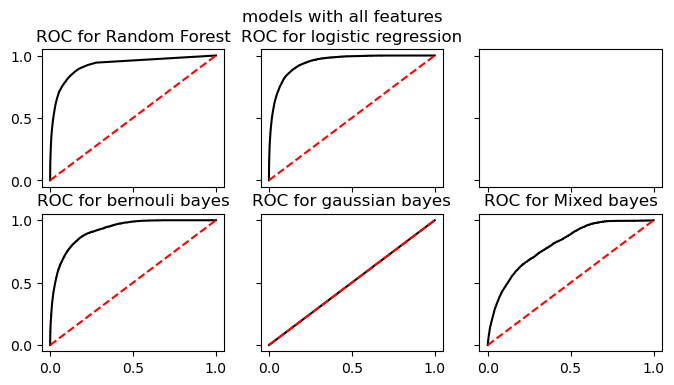

In [64]:
#plot all 
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':100})
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
fpr, tpr, thresholds = roc_curve(y_test, rf_red.predict_proba(X_test)[:,1])
ax[0][0].plot(fpr,tpr,'k')
ax[0][0].plot([0,1],[0,1],'r--')
ax[0][0].set_title('ROC for Random Forest')

fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
ax[0][1].plot(fpr,tpr,'k')
ax[0][1].plot([0,1],[0,1],'r--')
ax[0][1].set_title('ROC for logistic regression')

fpr, tpr, thresholds = roc_curve(y_test, bnb.predict_proba(X_test)[:,1])
ax[1][0].plot(fpr,tpr,'k')
ax[1][0].plot([0,1],[0,1],'r--')
ax[1][0].set_title('ROC for bernouli bayes')

fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
ax[1][1].plot(fpr,tpr,'k')
ax[1][1].plot([0,1],[0,1],'r--')
ax[1][1].set_title('ROC for gaussian bayes')

fpr, tpr, thresholds = roc_curve(y_test_MT, Mnb.predict_proba(X_test_MT)[:,1])
ax[1][2].plot(fpr,tpr,'k')
ax[1][2].plot([0,1],[0,1],'r--')
ax[1][2].set_title('ROC for Mixed bayes')

plt.suptitle('models with all features')